In [160]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D
from keras.initializers import random_uniform
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.optimizers import  SGD
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
from keras.layers import SimpleRNN
#from hyperas.distributions import uniform

from keras.utils.np_utils import to_categorical
from keras import regularizers
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [161]:
dataset = pd.read_csv(r'...') # use your path

In [162]:
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label
0,0,1,24,9,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,1,24,9,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,1,24,9,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,1,24,9,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,1,24,9,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [163]:
# Splitting dataset into features and labels.
labels = dataset['Label']
features = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [164]:
# For scaling the data, we use RobustScaler class from sklearn.

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [165]:
scaler = RobustScaler()
scaler.fit(features)

features = scaler.transform(features)

In [166]:
from sklearn.preprocessing import LabelEncoder

In [167]:
LE = LabelEncoder()

LE.fit(labels)
labels = LE.transform(labels)

In [168]:
# Labels have been replaced with integers.

np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [169]:
# Checking that encoding reversal works.

d = LE.inverse_transform(labels)
d = pd.Series(d)
d.unique()


array(['normal.', 'smurf.', 'neptune.', 'satan.', 'ipsweep.',
       'portsweep.', 'back.', 'nmap.', 'warezclient.', 'pod.',
       'teardrop.', 'guess_passwd.', 'land.', 'buffer_overflow.',
       'warezmaster.', 'multihop.', 'rootkit.', 'loadmodule.', 'phf.',
       'ftp_write.'], dtype=object)

### Splitting the data

In [170]:
from sklearn.model_selection import train_test_split

In [171]:
# The next step is to split training and testing data. For this we will use sklearn function train_test_split().

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 0.2,random_state=1)

In [172]:
features_train.shape, labels_train.shape ,features_test.shape , labels_test.shape

((1556449, 39), (1556449,), (389113, 39), (389113,))

In [173]:
features_train,  features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.25, random_state=1)
features_train.shape, labels_train.shape ,features_test.shape , labels_test.shape, features_val.shape ,labels_val.shape

((1167336, 39), (1167336,), (389113, 39), (389113,), (389113, 39), (389113,))

In [174]:
import datetime
import os
log_dir = os.path.join("train_logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# TF callback that stops training when best value of validationi loss function is reached
eary_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [175]:
# this function has evaluation metrics
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.4f} %'.format(precision_score(y_true, prediction, average='weighted') * 100))
    print('Recall-score: {:,.4f}'.format(recall_score(y_true, prediction, average='weighted') * 100))
    print('F1-score: {:,.4f}'.format(f1_score(y_true, prediction, average='weighted') * 100))

In [176]:
# plotting loss graphs w.r.t each epoch
def plotgraphs(model):
    f, ax = plt.subplots()
    ax.plot([None] + model.history.history["accuracy"], 'o-')
    ax.plot([None] + model.history.history["val_accuracy"], 'x-')

    ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
    ax.set_title('Training/Val Accuracy Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history["loss"], 'o-')
    ax.plot([None] + model.history.history["val_loss"], 'x-')

    ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
    ax.set_title('Training/Val Losses Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.show()

### DNN Models

In [177]:
dnn1= Sequential()

dnn1.add(Dense(256, activation='relu', input_shape=(features_train.shape[1],)))
dnn1.add(Dropout(0.1))
dnn1.add(Dense(20, activation='softmax'))

dnn1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 256)               10240     
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 20)                5140      
Total params: 15,380
Trainable params: 15,380
Non-trainable params: 0
_________________________________________________________________


In [178]:
dnn1.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [180]:
dnn1.fit(features_train,labels_train,epochs=30,batch_size=64,validation_data=(features_val,labels_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
18240/18240 [==============================] - 49s 3ms/step - loss: 0.1432 - accuracy: 0.9989 - val_loss: 9.3741 - val_accuracy: 0.9981
Epoch 2/30
18240/18240 [==============================] - 49s 3ms/step - loss: 0.1742 - accuracy: 0.9992 - val_loss: 12.5639 - val_accuracy: 0.9988
Epoch 3/30
18240/18240 [==============================] - 51s 3ms/step - loss: 0.0793 - accuracy: 0.9993 - val_loss: 19.1342 - val_accuracy: 0.9996
Epoch 4/30
18240/18240 [==============================] - 51s 3ms/step - loss: 0.1910 - accuracy: 0.9994 - val_loss: 17.1497 - val_accuracy: 0.9996
Epoch 5/30
18240/18240 [==============================] - 48s 3ms/step - loss: 0.1455 - accuracy: 0.9994 - val_loss: 16.1451 - val_accuracy: 0.9995
Epoch 6/30
18240/18240 [==============================] - 47s 3ms/step - loss: 0.0984 - accuracy: 0.9995 - val_loss: 16.0508 - val_accuracy: 0.9996
Epoch 7/30
18240/18240 [==============================] - 46s 3ms/step - loss: 0.1362 - accuracy: 0.9995 - val_lo

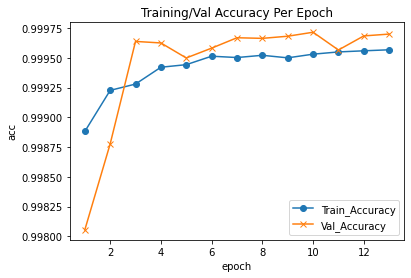

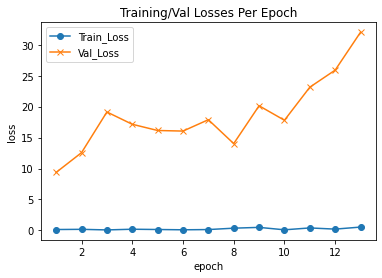

In [181]:
plotgraphs(dnn1)

In [182]:
predict = np.argmax(dnn1.predict(features_test),axis=1)

a = np.unique(predict)
b = np.unique(labels_test)
c = list(set(a) | set(b))

In [183]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       109
           1       0.00      0.00      0.00         2
           3       1.00      0.83      0.91         6
           4       0.96      0.97      0.97       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.93      0.98      0.95       105
          10       1.00      1.00      1.00    194326
          12       1.00      0.93      0.96        14
          13       0.99      0.90      0.94       557
          14       0.00      0.00      0.00         1
          15       0.99      0.98      0.98       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.85      0.85      0.85        65
          19       0.00      0.00      0.00         2

    accuracy    

In [184]:
dnn2= Sequential()

dnn2.add(Dense(256, activation='relu', input_shape=(features_train.shape[1],)))
dnn2.add(Dropout(0.1))
dnn2.add(Dense(128, activation='relu'))
dnn2.add(Dropout(0.1))
dnn2.add(Dense(20, activation = 'softmax'))

dnn2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 256)               10240     
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 20)                2580      
Total params: 45,716
Trainable params: 45,716
Non-trainable params: 0
_________________________________________________________________


In [185]:
dnn2.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [186]:
dnn2.fit(features_train,labels_train,epochs=30,batch_size=64,
         validation_data=(features_test,labels_test),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
18240/18240 [==============================] - 62s 3ms/step - loss: 0.6870 - accuracy: 0.9954 - val_loss: 0.5548 - val_accuracy: 0.9994
Epoch 2/30
18240/18240 [==============================] - 63s 3ms/step - loss: 0.3546 - accuracy: 0.9991 - val_loss: 0.7222 - val_accuracy: 0.9995
Epoch 3/30
18240/18240 [==============================] - 67s 4ms/step - loss: 0.3647 - accuracy: 0.9994 - val_loss: 0.7107 - val_accuracy: 0.9994
Epoch 4/30
18240/18240 [==============================] - 66s 4ms/step - loss: 0.0624 - accuracy: 0.9994 - val_loss: 1.2906 - val_accuracy: 0.9995
Epoch 5/30
18240/18240 [==============================] - 63s 3ms/step - loss: 0.2726 - accuracy: 0.9993 - val_loss: 0.8884 - val_accuracy: 0.9996
Epoch 6/30
18240/18240 [==============================] - 64s 4ms/step - loss: 0.0888 - accuracy: 0.9994 - val_loss: 2.0663 - val_accuracy: 0.9996
Epoch 7/30
18240/18240 [==============================] - 65s 4ms/step - loss: 0.1937 - accuracy: 0.9994 - val_loss: 1

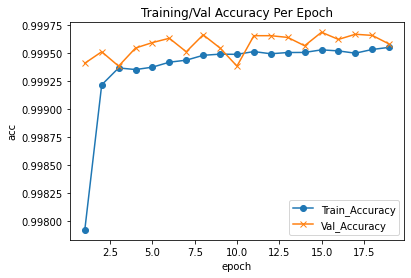

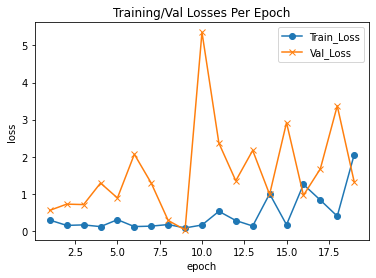

In [187]:
plotgraphs(dnn2)

In [188]:
predict = np.argmax(dnn2.predict(features_test),axis=1)

a = np.unique(predict)
b = np.unique(labels_test)
c = list(set(a) | set(b))

In [189]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       109
           1       0.00      0.00      0.00         2
           3       1.00      0.50      0.67         6
           4       0.99      0.90      0.95       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.98      0.99      0.99       105
          10       1.00      1.00      1.00    194326
          12       1.00      1.00      1.00        14
          13       1.00      0.90      0.95       557
          14       0.00      0.00      0.00         1
          15       0.99      0.98      0.99       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.94      0.75      0.84        65
          19       0.00      0.00      0.00         2

    accuracy    

In [190]:
dnn3= Sequential()

dnn3.add(Dense(256, activation='relu', input_shape=(features_train.shape[1],)))
dnn3.add(Dropout(0.1))
dnn3.add(Dense(128, activation='relu'))
dnn3.add(Dropout(0.1))
dnn3.add(Dense(64, activation='relu'))
dnn3.add(Dropout(0.1))
dnn3.add(Dense(20, activation = 'softmax'))

dnn3.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               10240     
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 20)              

In [191]:
dnn3.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [192]:
dnn3.fit(features_train,labels_train,epochs=30,batch_size=128,
         validation_data=(features_test,labels_test),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
9120/9120 [==============================] - 48s 5ms/step - loss: 0.2883 - accuracy: 0.9937 - val_loss: 0.2119 - val_accuracy: 0.9992
Epoch 2/30
9120/9120 [==============================] - 49s 5ms/step - loss: 0.0664 - accuracy: 0.9988 - val_loss: 0.0571 - val_accuracy: 0.9995
Epoch 3/30
9120/9120 [==============================] - 48s 5ms/step - loss: 0.0463 - accuracy: 0.9992 - val_loss: 0.0319 - val_accuracy: 0.9995
Epoch 4/30
9120/9120 [==============================] - 48s 5ms/step - loss: 0.0233 - accuracy: 0.9994 - val_loss: 0.0238 - val_accuracy: 0.9995
Epoch 5/30
9120/9120 [==============================] - 49s 5ms/step - loss: 0.0349 - accuracy: 0.9994 - val_loss: 0.0613 - val_accuracy: 0.9995
Epoch 6/30
9120/9120 [==============================] - 50s 5ms/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.0083 - val_accuracy: 0.9996
Epoch 7/30
9120/9120 [==============================] - 49s 5ms/step - loss: 0.0226 - accuracy: 0.9995 - val_loss: 0.0166 - val_ac

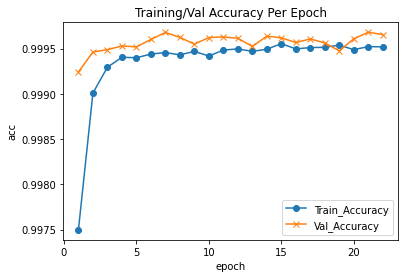

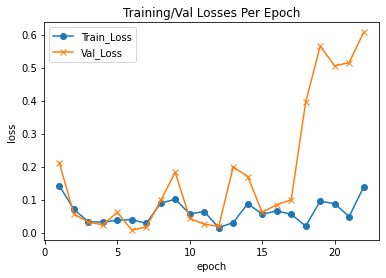

In [193]:
plotgraphs(dnn3)

In [194]:
predict = np.argmax(dnn3.predict(features_test),axis=1)

a = np.unique(predict)
b = np.unique(labels_test)
c = list(set(a) | set(b))

In [195]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       109
           1       0.00      0.00      0.00         2
           3       1.00      0.67      0.80         6
           4       0.96      0.96      0.96       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.95      0.99      0.97       105
          10       1.00      1.00      1.00    194326
          12       1.00      0.64      0.78        14
          13       0.99      0.91      0.95       557
          14       0.00      0.00      0.00         1
          15       1.00      0.98      0.99       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.96      0.75      0.84        65
          19       0.00      0.00      0.00         2

    accuracy    

### CNN Models

In [210]:
# reshape input to be [samples, time steps, features]
y_train= to_categorical(labels_train)
y_test= to_categorical(labels_test)
y_val= to_categorical(labels_val)

X_train = np.array(features_train).reshape(features_train.shape[0], features_train.shape[1], 1)
X_test = np.array(features_test).reshape(features_test.shape[0], features_test.shape[1], 1)
X_val = np.array(features_val).reshape(features_val.shape[0], features_val.shape[1], 1)
X_train.shape , X_test.shape , X_val.shape

((1167336, 39, 1), (389113, 39, 1), (389113, 39, 1))

In [227]:
y_train = np.asarray(labels_train).astype('float32').reshape((-1,1))
y_test = np.asarray(labels_test).astype('float32').reshape((-1,1))
y_val = np.asarray(labels_val).astype('float32').reshape((-1,1))

In [233]:
#hyperparameters
keras.backend.clear_session()
SEED = 1040941203
hidden_initializer = random_uniform(seed=SEED)


# create model
cnn3 = Sequential()
cnn3.add(Conv1D(64, 3, input_shape=(39, 1)))
cnn3.add(LeakyReLU(alpha=0.1))
cnn3.add(MaxPooling1D(pool_size=2))
cnn3.add(Dropout(0.3))

cnn3.add(Conv1D(64, 1))
cnn3.add(LeakyReLU(alpha=0.1))
cnn3.add(MaxPooling1D(pool_size=2))
cnn3.add(Dropout(0.3))

cnn3.add(Conv1D(64, 1))
cnn3.add(LeakyReLU(alpha=0.1))
cnn3.add(MaxPooling1D(pool_size=2))
cnn3.add(Dropout(0.3))

cnn3.add(Flatten())
cnn3.add(Dense(64, input_dim=19, kernel_initializer=hidden_initializer))
cnn3.add(LeakyReLU(alpha=0.1))
cnn3.add(Dense(32))
cnn3.add(LeakyReLU(alpha=0.1))
cnn3.add(Dense(20, activation='softmax'))

cnn3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 37, 64)            256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 37, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 64)            4160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 18, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 64)             0

In [236]:
cnn3.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [237]:
cnn3.fit(X_train, y_train, epochs=30, batch_size=512, 
         validation_data=(X_val,y_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
2280/2280 [==============================] - 143s 62ms/step - loss: 0.2840 - accuracy: 0.9583 - val_loss: 0.1268 - val_accuracy: 0.9970
Epoch 2/30
2280/2280 [==============================] - 141s 62ms/step - loss: 0.0181 - accuracy: 0.9960 - val_loss: 0.0308 - val_accuracy: 0.9980
Epoch 3/30
2280/2280 [==============================] - 140s 62ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.0123 - val_accuracy: 0.9980
Epoch 4/30
2280/2280 [==============================] - 141s 62ms/step - loss: 0.0119 - accuracy: 0.9976 - val_loss: 0.0566 - val_accuracy: 0.9986
Epoch 5/30
2280/2280 [==============================] - 141s 62ms/step - loss: 0.0162 - accuracy: 0.9982 - val_loss: 0.0156 - val_accuracy: 0.9989
Epoch 6/30
2280/2280 [==============================] - 142s 62ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0794 - val_accuracy: 0.9990
Epoch 7/30
2280/2280 [==============================] - 141s 62ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0

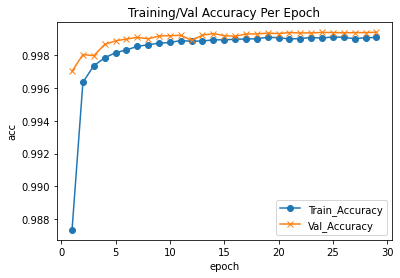

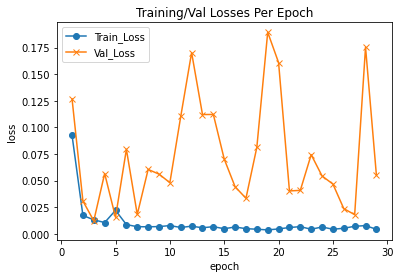

In [238]:
plotgraphs(cnn3)

In [239]:
predict = np.argmax(cnn3.predict(X_test),axis=1)

a = np.unique(predict)
b = np.unique(y_test)
c = list(set(a) | set(b))

In [240]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       109
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       1.00      0.83      0.91         6
           4       0.91      0.88      0.89       627
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00     53123
           9       0.98      0.48      0.64       105
          10       1.00      1.00      1.00    194326
          12       1.00      1.00      1.00        14
          13       0.99      0.97      0.98       557
          14       0.00      0.00      0.00         1
          15       1.00      0.96      0.98       777
          16       1.00      1.00      1.00    139354
          17       0.98      1.00      0.99        43
          18     

In [241]:
#hyperparameters
keras.backend.clear_session()
SEED = 1040941203
hidden_initializer = random_uniform(seed=SEED)


# create model
cnn2 = Sequential()
cnn2.add(Conv1D(64, 3, input_shape=(39, 1)))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(Dropout(0.3))

cnn2.add(Conv1D(64, 1))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(Dropout(0.3))

cnn2.add(Flatten())
cnn2.add(Dense(64, input_dim=20, kernel_initializer=hidden_initializer))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(Dense(32))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(Dense(20, activation='softmax'))

cnn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 37, 64)            256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 37, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 64)            4160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 37, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2368)              0

In [244]:
cnn2.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [245]:
cnn2.fit(X_train, y_train, epochs=30, batch_size=512, 
         validation_data=(X_val,y_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
2280/2280 [==============================] - 165s 72ms/step - loss: 0.1751 - accuracy: 0.9886 - val_loss: 0.1531 - val_accuracy: 0.9991
Epoch 2/30
2280/2280 [==============================] - 170s 75ms/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 0.2713 - val_accuracy: 0.9989
Epoch 3/30
2280/2280 [==============================] - 180s 79ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 0.1028 - val_accuracy: 0.9994
Epoch 4/30
2280/2280 [==============================] - 177s 78ms/step - loss: 0.0100 - accuracy: 0.9989 - val_loss: 0.0908 - val_accuracy: 0.9992
Epoch 5/30
2280/2280 [==============================] - 177s 78ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 0.0264 - val_accuracy: 0.9995
Epoch 6/30
2280/2280 [==============================] - 178s 78ms/step - loss: 0.0060 - accuracy: 0.9991 - val_loss: 0.1966 - val_accuracy: 0.9995
Epoch 7/30
2280/2280 [==============================] - 178s 78ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0

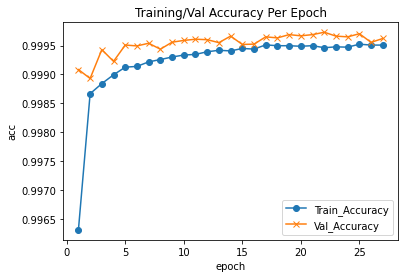

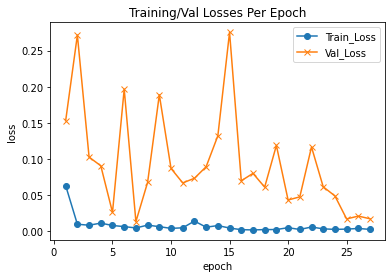

In [246]:
plotgraphs(cnn2)

In [247]:
predict = np.argmax(cnn2.predict(X_test),axis=1)

a = np.unique(predict)
b = np.unique(y_test)
c = list(set(a) | set(b))

In [248]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       0.00      0.00      0.00         2
           3       1.00      0.83      0.91         6
           4       0.99      0.93      0.96       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.96      0.90      0.93       105
          10       1.00      1.00      1.00    194326
          12       1.00      1.00      1.00        14
          13       0.99      0.98      0.99       557
          14       0.00      0.00      0.00         1
          15       0.99      0.98      0.99       777
          16       1.00      1.00      1.00    139354
          17       0.98      1.00      0.99        43
          18       0.90      0.54      0.67        65
          19       0.00      0.00      0.00         2

    accuracy    

In [249]:
#hyperparameters
keras.backend.clear_session()
SEED = 1040941203
hidden_initializer = random_uniform(seed=SEED)


# create model
cnn1 = Sequential()
cnn1.add(Conv1D(64, 3, input_shape=(39, 1)))
cnn1.add(LeakyReLU(alpha=0.1))
cnn1.add(Dropout(0.3))

cnn1.add(Flatten())
cnn1.add(Dense(64, input_dim=20, kernel_initializer=hidden_initializer))
cnn1.add(LeakyReLU(alpha=0.1))

cnn1.add(Dense(20, activation='softmax'))

cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 37, 64)            256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 37, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2368)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                151616    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1

In [250]:
cnn1.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
cnn1.fit(X_train, y_train, epochs=30, batch_size=256, 
         validation_data=(X_val,y_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
4560/4560 [==============================] - 118s 26ms/step - loss: 0.1931 - accuracy: 0.9937 - val_loss: 1.3481 - val_accuracy: 0.9977
Epoch 2/30
4560/4560 [==============================] - 116s 26ms/step - loss: 0.0274 - accuracy: 0.9985 - val_loss: 1.1443 - val_accuracy: 0.9993
Epoch 3/30
4560/4560 [==============================] - 115s 25ms/step - loss: 0.0251 - accuracy: 0.9988 - val_loss: 0.2429 - val_accuracy: 0.9993
Epoch 4/30
4560/4560 [==============================] - 117s 26ms/step - loss: 0.0177 - accuracy: 0.9990 - val_loss: 0.2769 - val_accuracy: 0.9987
Epoch 5/30
4560/4560 [==============================] - 117s 26ms/step - loss: 0.0205 - accuracy: 0.9991 - val_loss: 0.4627 - val_accuracy: 0.9994
Epoch 6/30
4560/4560 [==============================] - 117s 26ms/step - loss: 0.0168 - accuracy: 0.9991 - val_loss: 0.6180 - val_accuracy: 0.9996
Epoch 7/30
4560/4560 [==============================] - 116s 25ms/step - loss: 0.0094 - accuracy: 0.9991 - val_loss: 1

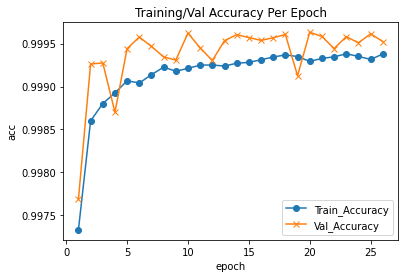

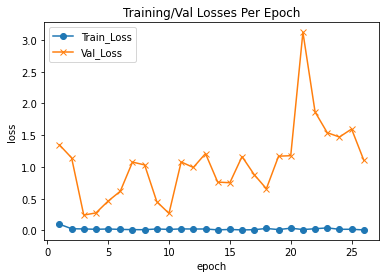

In [251]:
plotgraphs(cnn1)

In [252]:
predict = np.argmax(cnn1.predict(X_test),axis=1)

a = np.unique(predict)
b = np.unique(y_test)
c = list(set(a) | set(b))

In [253]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.89      0.98      0.93       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       1.00      0.48      0.65       105
          10       1.00      1.00      1.00    194326
          12       1.00      1.00      1.00        14
          13       0.99      0.98      0.98       557
          14       0.00      0.00      0.00         1
          15       1.00      0.96      0.98       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.73      0.17      0.28        65
          19       0.00      0.00      0.00         2

    accuracy    

### RNN Models

In [258]:
# reshape input to be [samples, time steps, features] for RNN
RNN_features_train = np.reshape(features_train, (features_train.shape[0],features_train.shape[1],1))
RNN_features_test = np.reshape(features_test, (features_test.shape[0],features_test.shape[1],1))
RNN_features_val = np.reshape(features_val, (features_val.shape[0],features_val.shape[1],1))

In [268]:
#hyperparameters

# Initialising the RNN
rnn3 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
rnn3.add(SimpleRNN(units = 32,activation='relu', return_sequences = True,  input_shape = (39,1)))
rnn3.add(Dropout(0.1))

# Adding a second RNN layer and some Dropout regularisation
rnn3.add(SimpleRNN(units = 32,activation='relu', return_sequences = True))
rnn3.add(Dropout(0.1))

# Adding a third RNN layer and some Dropout regularisation
rnn3.add(SimpleRNN(units = 32,activation='relu', return_sequences = True))
rnn3.add(Dropout(0.1))

# Adding the output layer
rnn3.add(Flatten())
rnn3.add(Dense(64, input_dim=20, kernel_initializer=hidden_initializer))
rnn3.add(LeakyReLU(alpha=0.1))
rnn3.add(Dense(32))
rnn3.add(LeakyReLU(alpha=0.1))
rnn3.add(Dense(units = 20, activation='softmax'))

rnn3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 39, 32)            1088      
_________________________________________________________________
dropout_6 (Dropout)          (None, 39, 32)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 39, 32)            2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 39, 32)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 39, 32)            2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 39, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1248)             

In [269]:
rnn3.compile(loss = "sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
rnn3.fit(RNN_features_train, y_train, epochs=30, batch_size=1000,
         validation_data=(RNN_features_val,y_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
1168/1168 [==============================] - 283s 240ms/step - loss: 0.4392 - accuracy: 0.9353 - val_loss: 0.0731 - val_accuracy: 0.9980
Epoch 2/30
1168/1168 [==============================] - 274s 235ms/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 0.1171 - val_accuracy: 0.9992
Epoch 3/30
1168/1168 [==============================] - 269s 230ms/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.0555 - val_accuracy: 0.9994
Epoch 4/30
1168/1168 [==============================] - 270s 231ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0202 - val_accuracy: 0.9994
Epoch 5/30
1168/1168 [==============================] - 271s 232ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0226 - val_accuracy: 0.9994
Epoch 6/30
1168/1168 [==============================] - 276s 237ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 7/30
1168/1168 [==============================] - 271s 232ms/step - loss: 0.0028 - accuracy: 0.9994 - val_

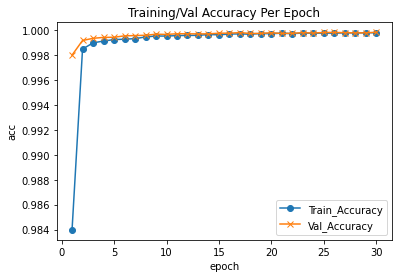

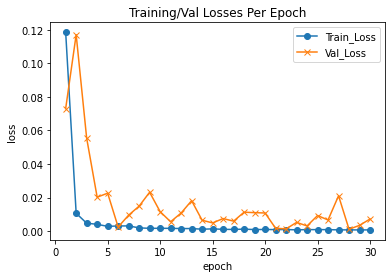

In [270]:
plotgraphs(rnn3)

In [271]:
predict = np.argmax(rnn3.predict(X_test),axis=1)

a = np.unique(predict)
b = np.unique(y_test)
c = list(set(a) | set(b))

In [272]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00         2
           3       1.00      0.83      0.91         6
           4       0.97      0.98      0.98       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.93      0.99      0.96       105
          10       1.00      1.00      1.00    194326
          12       0.93      1.00      0.97        14
          13       0.99      0.99      0.99       557
          14       0.00      0.00      0.00         1
          15       1.00      0.99      0.99       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.97      0.98      0.98        65
          19       1.00      1.00      1.00         2

    accuracy    

In [273]:
#hyperparameters

# Initialising the RNN
rnn2 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
rnn2.add(SimpleRNN(units = 32,activation='relu', return_sequences = True,  input_shape = (39,1)))
rnn2.add(Dropout(0.3))

# Adding the first RNN layer and some Dropout regularisation
rnn2.add(SimpleRNN(units = 32,activation='relu', return_sequences = True,  ))
rnn2.add(Dropout(0.3))

# Adding the output layer
rnn2.add(Flatten())
rnn2.add(Dense(64, input_dim=20, kernel_initializer=hidden_initializer))
rnn2.add(LeakyReLU(alpha=0.1))
rnn2.add(Dense(32))
rnn2.add(LeakyReLU(alpha=0.1))
rnn2.add(Dense(units = 20, activation='softmax'))

rnn2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 39, 32)            1088      
_________________________________________________________________
dropout_9 (Dropout)          (None, 39, 32)            0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 39, 32)            2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 39, 32)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1248)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                79936     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64)               

In [274]:
rnn2.compile(loss = "sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
rnn2.fit(RNN_features_train, y_train, epochs=30, batch_size=1000,
         validation_data=(RNN_features_val,y_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
1168/1168 [==============================] - 223s 189ms/step - loss: 0.4040 - accuracy: 0.9719 - val_loss: 0.0917 - val_accuracy: 0.9988
Epoch 2/30
1168/1168 [==============================] - 218s 187ms/step - loss: 0.0152 - accuracy: 0.9983 - val_loss: 0.0398 - val_accuracy: 0.9992
Epoch 3/30
1168/1168 [==============================] - 228s 195ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 0.0632 - val_accuracy: 0.9994
Epoch 4/30
1168/1168 [==============================] - 213s 183ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0301 - val_accuracy: 0.9993
Epoch 5/30
1168/1168 [==============================] - 214s 183ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.0087 - val_accuracy: 0.9992
Epoch 6/30
1168/1168 [==============================] - 214s 183ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0060 - val_accuracy: 0.9995
Epoch 7/30
1168/1168 [==============================] - 212s 181ms/step - loss: 0.0034 - accuracy: 0.9992 - val_

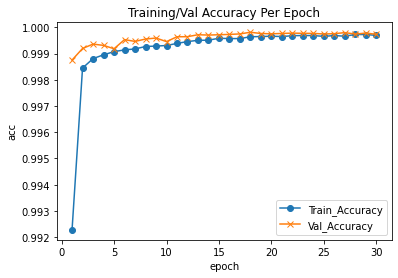

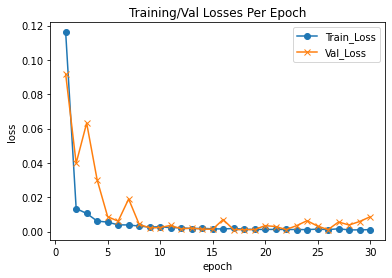

In [275]:
plotgraphs(rnn2)

In [276]:
predict = np.argmax(rnn2.predict(X_test),axis=1)

a = np.unique(predict)
b = np.unique(y_test)
c = list(set(a) | set(b))

In [277]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       109
           1       1.00      1.00      1.00         2
           3       1.00      0.83      0.91         6
           4       0.99      0.96      0.97       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.94      0.90      0.92       105
          10       1.00      1.00      1.00    194326
          12       1.00      1.00      1.00        14
          13       1.00      0.99      0.99       557
          14       0.00      0.00      0.00         1
          15       1.00      0.98      0.99       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.98      0.71      0.82        65
          19       1.00      0.50      0.67         2

    accuracy    

In [263]:
#hyperparameters

# Initialising the RNN
rnn1 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
rnn1.add(SimpleRNN(units = 64,activation='relu', return_sequences = True,  input_shape = (39,1)))
rnn1.add(Dropout(0.1))

# Adding the output layer
rnn1.add(Flatten())
rnn1.add(Dense(64, input_dim=20, kernel_initializer=hidden_initializer))
rnn1.add(LeakyReLU(alpha=0.1))
rnn1.add(Dense(32))
rnn1.add(LeakyReLU(alpha=0.1))
rnn1.add(Dense(units = 20, activation='softmax'))

rnn1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 39, 64)            4224      
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2496)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                159808    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32)               

In [264]:
rnn1.compile(loss = "sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
rnn1.fit(RNN_features_train, y_train, epochs=30, batch_size=1000,
         validation_data=(RNN_features_val,y_val),callbacks=[tensorboard_callback, eary_stop_callback])

Epoch 1/30
1168/1168 [==============================] - 147s 124ms/step - loss: 0.3711 - accuracy: 0.9829 - val_loss: 0.2357 - val_accuracy: 0.9990
Epoch 2/30
1168/1168 [==============================] - 144s 123ms/step - loss: 0.0135 - accuracy: 0.9987 - val_loss: 0.0457 - val_accuracy: 0.9995
Epoch 3/30
1168/1168 [==============================] - 142s 121ms/step - loss: 0.0286 - accuracy: 0.9991 - val_loss: 0.0902 - val_accuracy: 0.9992
Epoch 4/30
1168/1168 [==============================] - 142s 121ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.1028 - val_accuracy: 0.9994
Epoch 5/30
1168/1168 [==============================] - 141s 121ms/step - loss: 0.0066 - accuracy: 0.9993 - val_loss: 0.0140 - val_accuracy: 0.9996
Epoch 6/30
1168/1168 [==============================] - 143s 123ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0320 - val_accuracy: 0.9995
Epoch 7/30
1168/1168 [==============================] - 142s 121ms/step - loss: 0.0105 - accuracy: 0.9992 - val_

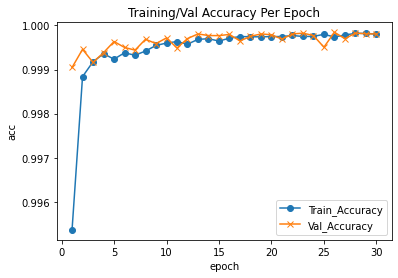

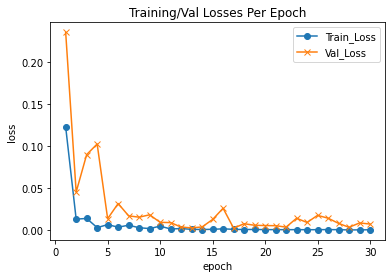

In [265]:
plotgraphs(rnn1)

In [266]:
predict = np.argmax(rnn1.predict(X_test),axis=1)

a = np.unique(predict)
b = np.unique(y_test)
c = list(set(a) | set(b))

In [267]:
report(predict,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       109
           1       1.00      1.00      1.00         2
           3       1.00      0.83      0.91         6
           4       1.00      0.98      0.99       627
           5       0.00      0.00      0.00         2
           8       1.00      1.00      1.00     53123
           9       0.98      0.96      0.97       105
          10       1.00      1.00      1.00    194326
          12       0.93      1.00      0.97        14
          13       1.00      0.98      0.99       557
          14       0.00      0.00      0.00         1
          15       1.00      0.98      0.99       777
          16       1.00      1.00      1.00    139354
          17       1.00      1.00      1.00        43
          18       0.98      0.86      0.92        65
          19       0.00      0.00      0.00         2

    accuracy    